In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm

In [2]:
def get_data(is_one_signal=True):
    file = open('./data/shashlik_61_pulses.txt', 'r')
    data = file.readlines()
    data = np.array([list(map(float, experiment.split())) for experiment in data])
   
    X = data[:, 2:]
    y_baseline = data[:, 1]
    y = data[:, 0]
    
    
    X = np.array([experiment - np.max(experiment) for experiment in X])
    X = np.array([experiment/-np.min(experiment) for experiment in X])

    y = np.round(y)
    y = y.astype(int)
    
    if is_one_signal:
        mean_argmin = int(np.argmin(X, axis=1).mean())
        for i in range(len(X)):
            cur_argmin = np.argmin(X[i])
            X[i] = signal_cyclic_shift(X[i], mean_argmin - cur_argmin)
            y[i] = y[i] + mean_argmin - cur_argmin;
            
#         X = np.array([signal_cyclic_shift(signal, mean_argmin - np.argmin(signal)) for signal in X])
#         y = np.array([ref_time - np.argmin])
    ## Let's shift each signal so that reference time matches for each signal

    else:
        mean_ref_time = int(y.mean())
        X = np.array([signal_cyclic_shift(signal, mean_ref_time - y[i]) for i, signal in enumerate(X, 0)])
        y = np.array([mean_ref_time]*len(y))

    return X, y

def get_freq_data(X, freq=1, start_point=384):
    X_freq = np.concatenate([X[:, start_point::-freq][:, ::-1], X[:, start_point + freq::freq]], axis=1)
    return X_freq

def signal_cyclic_shift(signal, tau):
    signal_start = signal[:-tau]
    
    new_signal = np.concatenate([signal[-tau:], signal_start])
    
    return new_signal

In [3]:
X_two_signals, y_two_signals = get_data(is_one_signal=False)

mean_argmin =  int(np.argmin(X_two_signals, axis=1).mean())

In [4]:
X_two_signals_train, X_two_signals_test, y_two_signals_train, y_two_signals_test = train_test_split(X_two_signals,\
                                                                                    y_two_signals, test_size=0.2, shuffle=False)

In [5]:
def get_ref_time(first_impulse, second_impulse, first_ref_time, second_ref_time):
    if np.min(first_impulse) < np.min(second_impulse):
         return first_ref_time
    else:
        return second_ref_time

In [6]:
import random

def generate_multi_signal(X_origin, y_origin, tau, alpha, to_plot=False):
    first_idx, second_idx = np.random.choice(X_origin.shape[0], 2, replace=False)
    first_impulse = X_origin[first_idx]
    second_impulse = X_origin[second_idx]
    
    
    first_ref_time = y_origin[first_idx]
    second_ref_time = y_origin[second_idx]
    
    
#     print("SHIFT:", tau)
#     print("BEFORE SHIFT:", first_ref_time, second_ref_time)
    ### Randomly choose what signal to shift
#     if random.choice([True, False]):
#         first_impulse = signal_cyclic_shift(first_impulse, tau)
#         first_ref_time += tau
#     else:
#         second_impulse = signal_cyclic_shift(second_impulse, tau)
#         second_ref_time += tau
    second_impulse = signal_cyclic_shift(second_impulse, tau)
    second_ref_time += tau
    
#     print("AFTER SHIFT:", first_ref_time, second_ref_time)
    
    multi_impulse = first_impulse + second_impulse*alpha
    multi_impulse /= -np.min(multi_impulse)
    
    first_impulse_shifted = signal_cyclic_shift(first_impulse, mean_argmin - np.argmin(first_impulse))
    second_impulse_shifted = signal_cyclic_shift(second_impulse, mean_argmin - np.argmin(second_impulse))
    multi_impulse_shifted = signal_cyclic_shift(multi_impulse, mean_argmin - np.argmin(multi_impulse))

#     print(mean_argmin - np.argmin(multi_impulse))
    first_ref_time +=  mean_argmin - np.argmin(multi_impulse)
    second_ref_time +=  mean_argmin - np.argmin(multi_impulse)
    
    if to_plot:
        plt.plot(first_impulse)
        plt.plot(second_impulse)
        plt.plot(multi_impulse_shifted)
        plt.legend(['First signal', 'Second signal', 'Sum of signals'])
        plt.show()
        
    ref_time = get_ref_time(first_impulse, second_impulse*alpha, first_ref_time, second_ref_time)
    
    return {'first_impulse': first_impulse_shifted,\
            'second_impulse': second_impulse_shifted,\
            'ref_time': ref_time,\
            'multi_impulse': multi_impulse_shifted}

In [7]:
from sklearn.utils import shuffle

def prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=1000, to_print=False):    
    X = []
    y = []
    alpha_values = []
    tau_values = []
    for i in range(data_size):
        alpha = random.choice(alpha_range)
        tau = random.choice(tau_range)
        signal = generate_multi_signal(X_origin, y_origin, tau, alpha)
        
        
        X.append(signal['multi_impulse'])
        y.append(signal['ref_time']) 
        
        alpha_values.append(alpha)
        tau_values.append(tau)
   
    X = np.array(X)
    y = np.array(y)
    
    if to_print:
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

#     plt.scatter(alpha_values, tau_values)
#     plt.show()
    
    return X, y

In [8]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


tau_train_range = list(map(int, get_truncated_normal(mean=0, sd=10, low=-40, upp=40).rvs(1000)))
tau_test_range = list(map(int, get_truncated_normal(mean=0, sd=10, low=-40, upp=40).rvs(1000)))
alpha_train_range = np.array([np.around(10**i, decimals=4) for i in np.arange(-3, 0.05, 0.05)])
alpha_test_range = np.array([0, 0.01, 0.05, 0.1, 0.5, 1])
freq_values = [1, 25, 50, 75, 100]

In [9]:
import xgboost as xgb
from sklearn.model_selection import cross_validate
from math import sqrt

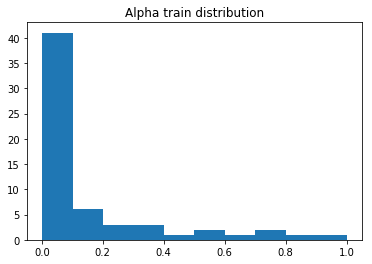

In [10]:
plt.title("Alpha train distribution")
plt.hist(alpha_train_range)
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
two_signals_scores = {alpha:[] for alpha in alpha_test_range}

In [13]:
model = xgb.XGBRegressor(objective="reg:linear", alpha= 0.01, booster='gbtree', eta= 0.323, gamma=0.189, 
                               reg_lambda=0.48, max_depth=6, verbosity=0)

In [14]:
TEST_SIZE = len(X_two_signals_test)
TIME_SCALE_COEF = 0.2

for freq in freq_values:
    X_train, y_train = prepare_data(X_two_signals_train, y_two_signals_train, tau_train_range, alpha_train_range, data_size=len(X_two_signals))
    X_train_freq = get_freq_data(X_train, freq=freq)
    model.fit(X_train_freq, y_train)
    
    for alpha in tqdm.tqdm(alpha_test_range):
        X_test_cur, y_test_cur = prepare_data(X_two_signals_test, y_two_signals_test, tau_test_range, [alpha], data_size=TEST_SIZE)
        X_test_freq = get_freq_data(X_test_cur, freq=freq)
        y_pred = model.predict(X_test_freq)
        two_signals_scores[alpha].append(sqrt(mean_squared_error(y_pred, y_test_cur)) * TIME_SCALE_COEF)

100%|██████████| 6/6 [00:03<00:00,  1.95it/s]


In [15]:
alpha_one_signal_test = [0, 0.01, 0.05] 
one_signal_scores = {alpha: [] for alpha in alpha_one_signal_test} 
one_signal_scores[-1] = [] ### -1 - predict for one signal data

In [16]:
X_one_signal, y_one_signal = get_data(is_one_signal=True)

In [17]:
X_one_signal_train, X_one_signal_test, y_one_signal_train, y_one_signal_test = train_test_split(X_one_signal,\
                                                                                    y_one_signal, test_size=0.2, shuffle=False)

In [18]:
for freq in tqdm.tqdm(freq_values):
    X_train_freq = get_freq_data(X_one_signal_train, freq=freq, start_point=mean_argmin)
    model.fit(X_train_freq, y_one_signal_train)
    X_test_freq = get_freq_data(X_one_signal_test, freq=freq, start_point=mean_argmin)
    y_pred = model.predict(X_test_freq)
    one_signal_scores[-1].append(sqrt(mean_squared_error(y_pred, y_one_signal_test)) * TIME_SCALE_COEF)

100%|██████████| 5/5 [00:55<00:00, 11.03s/it]


In [19]:
for freq in freq_values:
    X_train_freq = get_freq_data(X_one_signal_train, freq=freq, start_point=mean_argmin)
    model.fit(X_train_freq, y_one_signal_train)
    
    for alpha in tqdm.tqdm(alpha_one_signal_test):
        X_test_cur, y_test_cur = prepare_data(X_two_signals_test, y_two_signals_test, tau_test_range, [alpha], data_size=TEST_SIZE)
        X_test_freq = get_freq_data(X_test_cur, freq=freq)
        y_pred = model.predict(X_test_freq)
        one_signal_scores[alpha].append(sqrt(mean_squared_error(y_pred, y_test_cur)) * TIME_SCALE_COEF)

100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


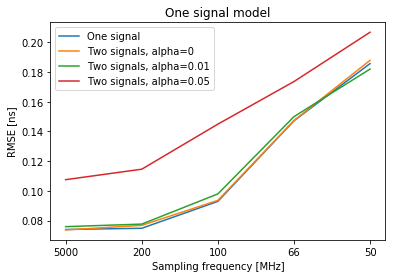

In [20]:
ORIGIN_FREQ = 5000


plt.title("One signal model")
for alpha in [-1] + alpha_one_signal_test:
    plt.plot(one_signal_scores[alpha])
plt.ylabel("RMSE [ns]")
plt.xlabel("Sampling frequency [MHz]")
plt.xticks(range(len(freq_values)), [int(ORIGIN_FREQ/freq) for freq in freq_values])
plt.legend(["One signal"] + ["Two signals, alpha=" + str(a) for a in alpha_one_signal_test])
plt.show()

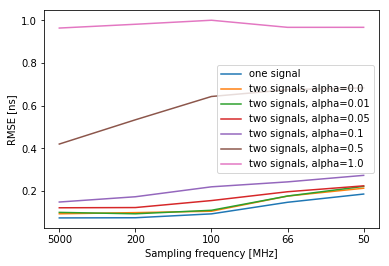

In [21]:
plt.plot(one_signal_scores[-1])

for alpha in two_signals_scores.keys():
    plt.plot(two_signals_scores[alpha])

plt.ylabel("RMSE [ns]")
plt.xlabel("Sampling frequency [MHz]")
plt.xticks(range(len(freq_values)), [int(ORIGIN_FREQ/freq) for freq in freq_values])
plt.legend(['one signal'] + ['two signals, alpha=' + str(key) for key in two_signals_scores.keys()])
plt.show()

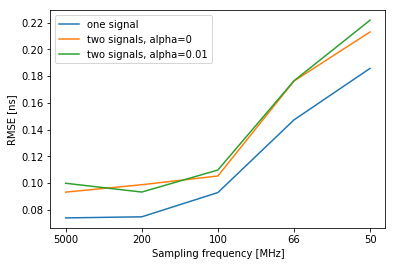

In [23]:
plt.plot(one_signal_scores[-1])
plt.plot(two_signals_scores[0])
plt.plot(two_signals_scores[0.01])
plt.ylabel("RMSE [ns]")
plt.xlabel("Sampling frequency [MHz]")
plt.xticks(range(len(freq_values)), [int(ORIGIN_FREQ/freq) for freq in freq_values])
plt.legend(['one signal', 'two signals, alpha=0', 'two signals, alpha=0.01'])
plt.show()

### -----------------------------------------------

In [33]:
X_two_signals, y_two_signals = get_data(is_one_signal=False)
mean_argmin =  int(np.argmin(X_two_signals, axis=1).mean())

X_two_signals_train, X_two_signals_test, y_two_signals_train, y_two_signals_test = train_test_split(X_two_signals,\
                                                                                    y_two_signals, test_size=0.2, shuffle=False)

In [34]:
X_one_signal, y_one_signal = get_data(is_one_signal=True)

In [35]:
X_one_signal_train, X_one_signal_test, y_one_signal_train, y_one_signal_test = train_test_split(X_one_signal,\
                                                                                    y_one_signal, test_size=0.2, shuffle=False)

In [37]:
X_one_signal_test.shape

(1570, 1024)

In [38]:
X_two_signals_test.shape

(1570, 1024)

In [39]:
for i in range(len(X_two_signals_test)):
    cur_argmin = np.argmin(X_two_signals_test[i])
    X_two_signals_test[i] = signal_cyclic_shift(X_two_signals_test[i], mean_argmin - cur_argmin)
    y_two_signals_test[i] += mean_argmin - cur_argmin

(array([  6.,  19., 287., 353., 413., 457.,  31.,   2.,   0.,   2.]),
 array([160. , 161.4, 162.8, 164.2, 165.6, 167. , 168.4, 169.8, 171.2,
        172.6, 174. ]),
 <a list of 10 Patch objects>)

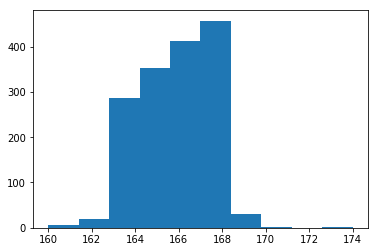

In [40]:
plt.hist(y_one_signal_test)

(array([  6.,  19., 287., 353., 413., 457.,  31.,   2.,   0.,   2.]),
 array([160. , 161.4, 162.8, 164.2, 165.6, 167. , 168.4, 169.8, 171.2,
        172.6, 174. ]),
 <a list of 10 Patch objects>)

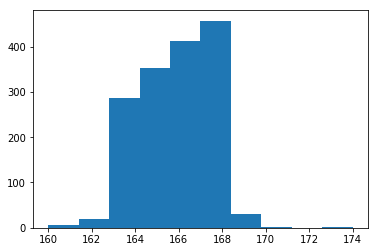

In [41]:
plt.hist(y_two_signals_test)

In [42]:
X_two_signals_test[0]

array([-0.01551657, -0.01423485, -0.01425427, ..., -0.01294666,
       -0.01358752, -0.01360694])

In [31]:
X_one_signal_test[0]

array([-0.01551657, -0.01423485, -0.01425427, ..., -0.01294666,
       -0.01358752, -0.01360694])

### --------------------------------------------